## Cryptocurrency Price Prediction using LSTM from Scratch TensorFlow


In [84]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf


In [85]:

# Load Data
data = yf.download('BTC-USD', start='2010-01-01', end='2025-06-01')
close_prices = data['Close'].values.reshape(-1, 1)

print(data.head(1))
print("Data loaded successfully.")

C:\Users\vedan\AppData\Local\Temp\ipykernel_22964\3554368497.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2010-01-01', end='2025-06-01')
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
Data loaded successfully.


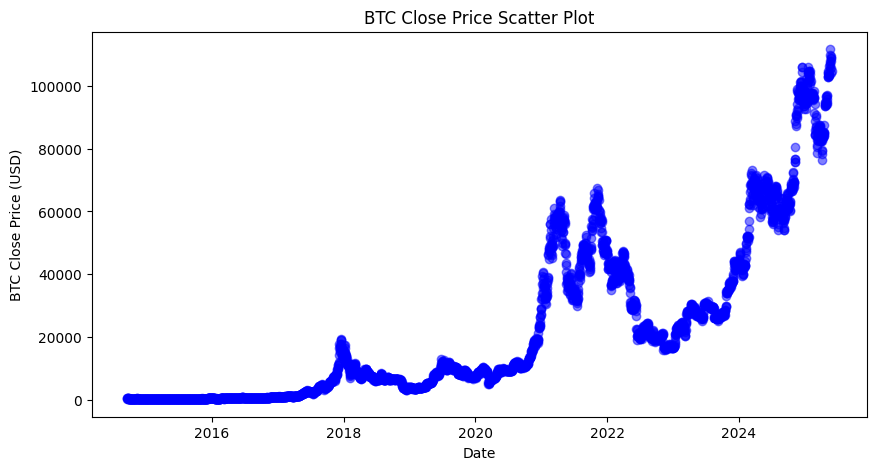

In [86]:
plt.figure(figsize=(10, 5))
plt.scatter(data.index, data['Close'], color='blue', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('BTC Close Price (USD)')
plt.title('BTC Close Price Scatter Plot')
plt.show()

In [87]:

# Normalize Data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

In [88]:
# Prepare Sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(scaled_prices, SEQ_LENGTH)

In [89]:
# Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [90]:
# Hyperparameters
hidden_size = 50
lr = 0.0001
epochs = 50
batch_size = 32

In [91]:
# Initialize Weights
def init_weights(shape):
    return tf.Variable(tf.random.truncated_normal(shape, stddev=0.05))

W_f = init_weights([hidden_size + 1, hidden_size])
b_f = tf.Variable(tf.zeros([hidden_size]))

W_i = init_weights([hidden_size + 1, hidden_size])
b_i = tf.Variable(tf.zeros([hidden_size]))

W_c = init_weights([hidden_size + 1, hidden_size])
b_c = tf.Variable(tf.zeros([hidden_size]))

W_o = init_weights([hidden_size + 1, hidden_size])
b_o = tf.Variable(tf.zeros([hidden_size]))

W_y = init_weights([hidden_size, 1])
b_y = tf.Variable(tf.zeros([1]))

In [92]:
# LSTM Cell (Single Step)
def lstm_cell(x_t, h_t_prev, c_t_prev):
    concat = tf.concat([h_t_prev, x_t], axis=1)
    f_t = tf.sigmoid(tf.matmul(concat, W_f) + b_f)
    i_t = tf.sigmoid(tf.matmul(concat, W_i) + b_i)
    c_tilde = tf.tanh(tf.matmul(concat, W_c) + b_c)
    c_t = f_t * c_t_prev + i_t * c_tilde
    o_t = tf.sigmoid(tf.matmul(concat, W_o) + b_o)
    h_t = o_t * tf.tanh(c_t)
    return h_t, c_t

In [93]:
# Training Loop
optimizer = tf.optimizers.Adam(lr)
loss_fn = tf.losses.MeanSquaredError()

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Ensure consistent dtype
        X_batch = tf.convert_to_tensor(X_batch, dtype=tf.float32)
        y_batch = tf.convert_to_tensor(y_batch, dtype=tf.float32)

        with tf.GradientTape() as tape:
            h_t = tf.zeros([X_batch.shape[0], hidden_size], dtype=tf.float32)
            c_t = tf.zeros([X_batch.shape[0], hidden_size], dtype=tf.float32)

            for t in range(SEQ_LENGTH):
                x_t = tf.reshape(X_batch[:, t], [-1, 1])  
                x_t = tf.cast(x_t, dtype=tf.float32)      
                h_t, c_t = lstm_cell(x_t, h_t, c_t)

            y_pred = tf.matmul(h_t, W_y) + b_y
            loss = loss_fn(y_batch, y_pred)

        grads = tape.gradient(loss, [W_f, b_f, W_i, b_i, W_c, b_c, W_o, b_o, W_y, b_y])
        optimizer.apply_gradients(zip(grads, [W_f, b_f, W_i, b_i, W_c, b_c, W_o, b_o, W_y, b_y]))
        
        total_loss += loss.numpy()
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')


Epoch 1/50, Loss: 0.029436
Epoch 2/50, Loss: 0.024806
Epoch 3/50, Loss: 0.019678
Epoch 4/50, Loss: 0.016404
Epoch 5/50, Loss: 0.015628
Epoch 6/50, Loss: 0.013886
Epoch 7/50, Loss: 0.011384
Epoch 8/50, Loss: 0.007586
Epoch 9/50, Loss: 0.006190
Epoch 10/50, Loss: 0.005488
Epoch 11/50, Loss: 0.004264
Epoch 12/50, Loss: 0.003284
Epoch 13/50, Loss: 0.003278
Epoch 14/50, Loss: 0.002972
Epoch 15/50, Loss: 0.002960
Epoch 16/50, Loss: 0.002733
Epoch 17/50, Loss: 0.002694
Epoch 18/50, Loss: 0.002529
Epoch 19/50, Loss: 0.002468
Epoch 20/50, Loss: 0.002346
Epoch 21/50, Loss: 0.002272
Epoch 22/50, Loss: 0.002175
Epoch 23/50, Loss: 0.002098
Epoch 24/50, Loss: 0.002016
Epoch 25/50, Loss: 0.001941
Epoch 26/50, Loss: 0.001867
Epoch 27/50, Loss: 0.001796
Epoch 28/50, Loss: 0.001727
Epoch 29/50, Loss: 0.001661
Epoch 30/50, Loss: 0.001597
Epoch 31/50, Loss: 0.001536
Epoch 32/50, Loss: 0.001476
Epoch 33/50, Loss: 0.001418
Epoch 34/50, Loss: 0.001363
Epoch 35/50, Loss: 0.001309
Epoch 36/50, Loss: 0.001257
E

In [94]:
# Prediction 

X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Initialize hidden and cell states
h_t = tf.zeros([X_test_tensor.shape[0], hidden_size], dtype=tf.float32)
c_t = tf.zeros([X_test_tensor.shape[0], hidden_size], dtype=tf.float32)

# Run through sequence length
for t in range(SEQ_LENGTH):
    x_t = tf.reshape(X_test_tensor[:, t], [-1, 1])  # shape: [batch_size, 1]
    h_t, c_t = lstm_cell(x_t, h_t, c_t)

# Compute predictions
y_pred_tensor = tf.matmul(h_t, W_y) + b_y

# Convert to numpy and inverse transform
y_pred = y_pred_tensor.numpy().reshape(-1, 1)
y_actual = y_test.reshape(-1, 1)

y_pred_scaled = scaler.inverse_transform(y_pred)
y_actual_scaled = scaler.inverse_transform(y_actual)

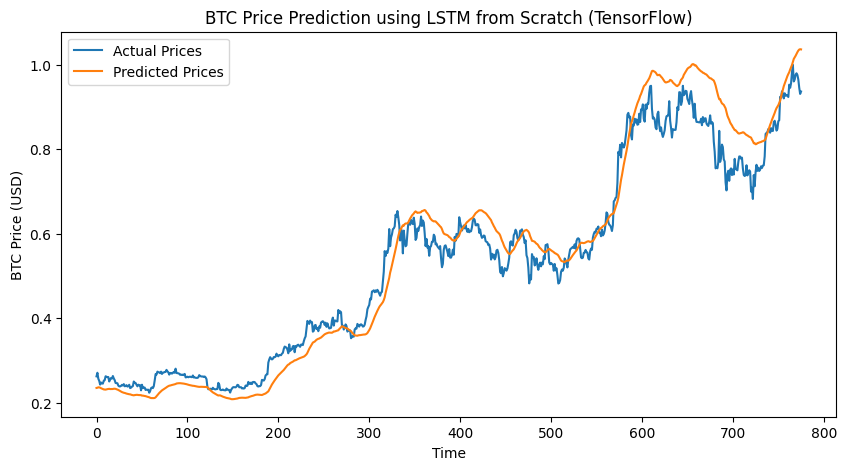

In [95]:

# Visualization
plt.figure(figsize=(10,5))
plt.plot(y_actual, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction using LSTM from Scratch (TensorFlow)')
plt.legend()
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_actual_scaled, y_pred_scaled)
r2 = r2_score(y_actual_scaled, y_pred_scaled)
ms=np.sqrt(mse)
print(f'Mean Error: {ms:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Error: 6179.1272
R^2 Score: 0.9413
